# Input Data

In [1]:
set.seed(64)
library("limma")
library("edgeR")
library("caret")

Loading required package: lattice

Loading required package: ggplot2



In [2]:
countNA <- function(x=NULL,cutOff=NULL){
  output<-FALSE
  perc<-sum(is.na(x))*100/length(x)
  if(perc>cutOff){output<-TRUE}
  output  
}

# Try

In [4]:
filter <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/GideHugoRiazAmatoLiu_AntiPD1_filtered.rds")
train <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/GideHugoRiazAmatoLiu_AntiPD1_train.rds")

In [ ]:
head(raw)
head(filter)
head(train)

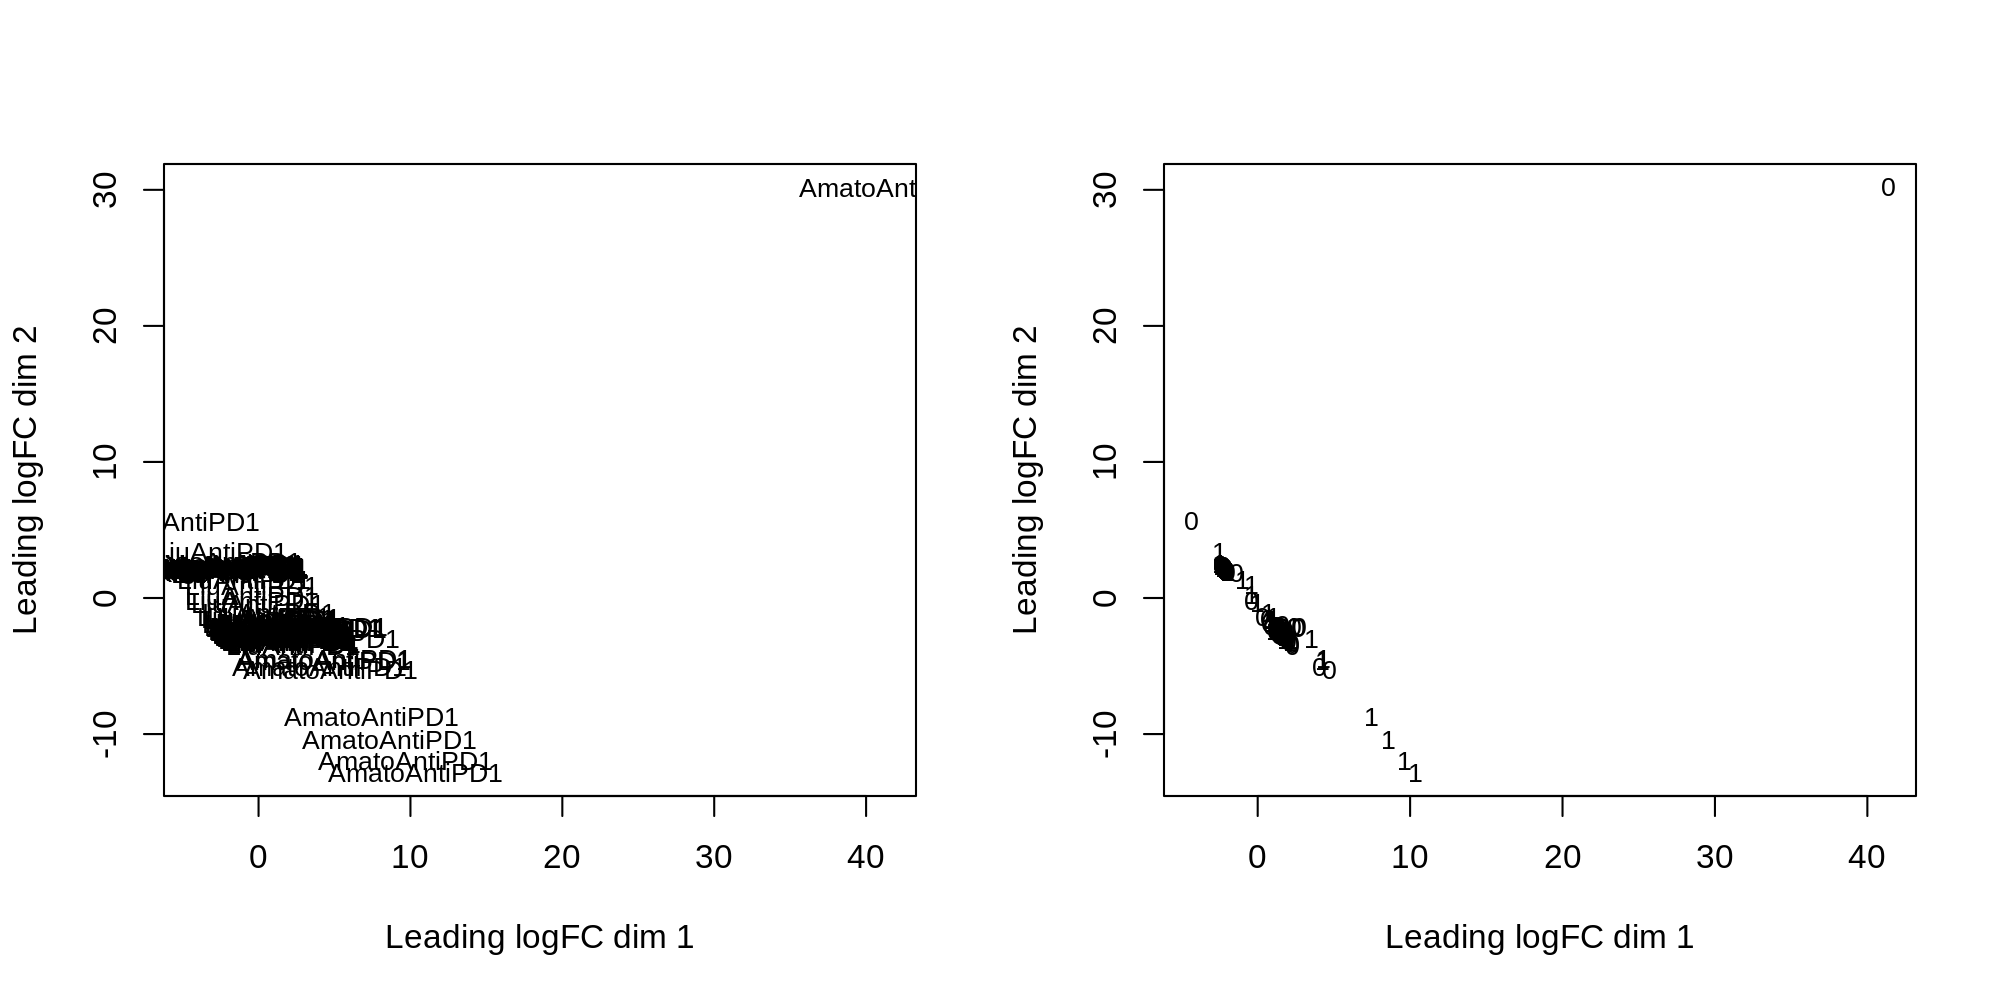

In [5]:
data <- filter

rmc <- c("Patient", "OS", "OS.Event", "RECIST", "Age", "Gender", "Response", "Source")
exp <- data[, -which(colnames(data) %in% rmc)]
exp <- t(exp)



# trainTransformed <- predict(preProcess(exp, methods=c("center", "scale")), exp)

options(repr.plot.height=5, repr.plot.width=10, repr.plot.res=200)
par(mfrow=c(1,2))
plotMDS(exp, labels=data$Source, pch=19, cex=0.8)
plotMDS(exp, labels=as.character(data$Response), pch=19, cex=0.8)

In [16]:
# path <- "/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/GideHugoRiazAmatoLiu_AntiPD1_train.rds"
# train_pos <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/GideHugoRiazAmatoLiu_AntiPD1_train_pos.rds")


# data <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/GideHugoRiazAmatoLiu_AntiPD1_train.rds")

data <- read.csv("/home/jp/ICP_Responders/DataCollectionFormatting/MergeTables/GideHugoRiazAmatoLiu_AntiPD1.csv", check.names=FALSE)

nrow(data)
# head(data)

# Check which rows has > 50% NA values
row_nas <- apply(data,1,function(x){countNA(x, 50)})
cat("Rows with NAs > 50% = ", sum(row_nas), "\n")
# 25 rows have 100% NAs, removing them
data <- data[-which(row_nas %in% TRUE),]


# expression matrix
rmc <- c("Patient", "OS", "OS.Event", "RECIST", "Age", "Gender", "Response", "Source")
exp <- data[, -which(colnames(data) %in% rmc)]
sample_names <- rownames(exp)
exp <- t(exp)
colnames(exp) <- sample_names

# phenotype
sc <- c("Response", "Source")
ph <- data[, which(colnames(data) %in% sc)]
ph$src <- gsub("(.).*", "\\1", ph$Source)
ph$clr <- "green"
ph[ph$src == "R",]$clr <- "red" 
ph[ph$src == "H",]$clr <- "blue"
ph[ph$src == "A",]$clr <- "purple"
ph[ph$src == "L",]$clr <- "black"


ph$clr_res <- "green"
ph[ph$Response == 0,]$clr_res <- "gray"

[1] 205

Rows with NAs > 50% =  25 


# Remove Batch Effect

In [ ]:
# design <- model.matrix(~0+as.factor(ph$Response))
# exp_be <-  removeBatchEffect(exp, batch=ph$Source, design=design)

In [ ]:
# head(exp)
# head(exp_be)

# Filter lowly expressed genes
Not Used

In [ ]:
# # select genes with an expression above threshold x in p% of samples
# nsmp <- ncol(exp)
# x <- 1  # 2 counts per million = log2 = 1
# n <- 5  # minimum 5 samples
# ridx <- rowSums(exp>x) > n
# table(ridx)
# expf <- exp[ridx, ]
# dim(expf)

# Normalise the data

In [ ]:
# exp <- data[, 3:(ncol(data)-1)]
# trainTransformed <- predict(preProcess(exp, methods=c("center", "scale")), exp)
# data[, 3:(ncol(data)-1)] <- trainTransformed

In [10]:
trainTransformed <- predict(preProcess(exp, methods=c("center", "scale")), exp)
# design <- model.matrix(~0+as.factor(ph$Response))
# trainTransformed_be <-  removeBatchEffect(trainTransformed, batch=ph$Source, design=design)

# Look for batch effects

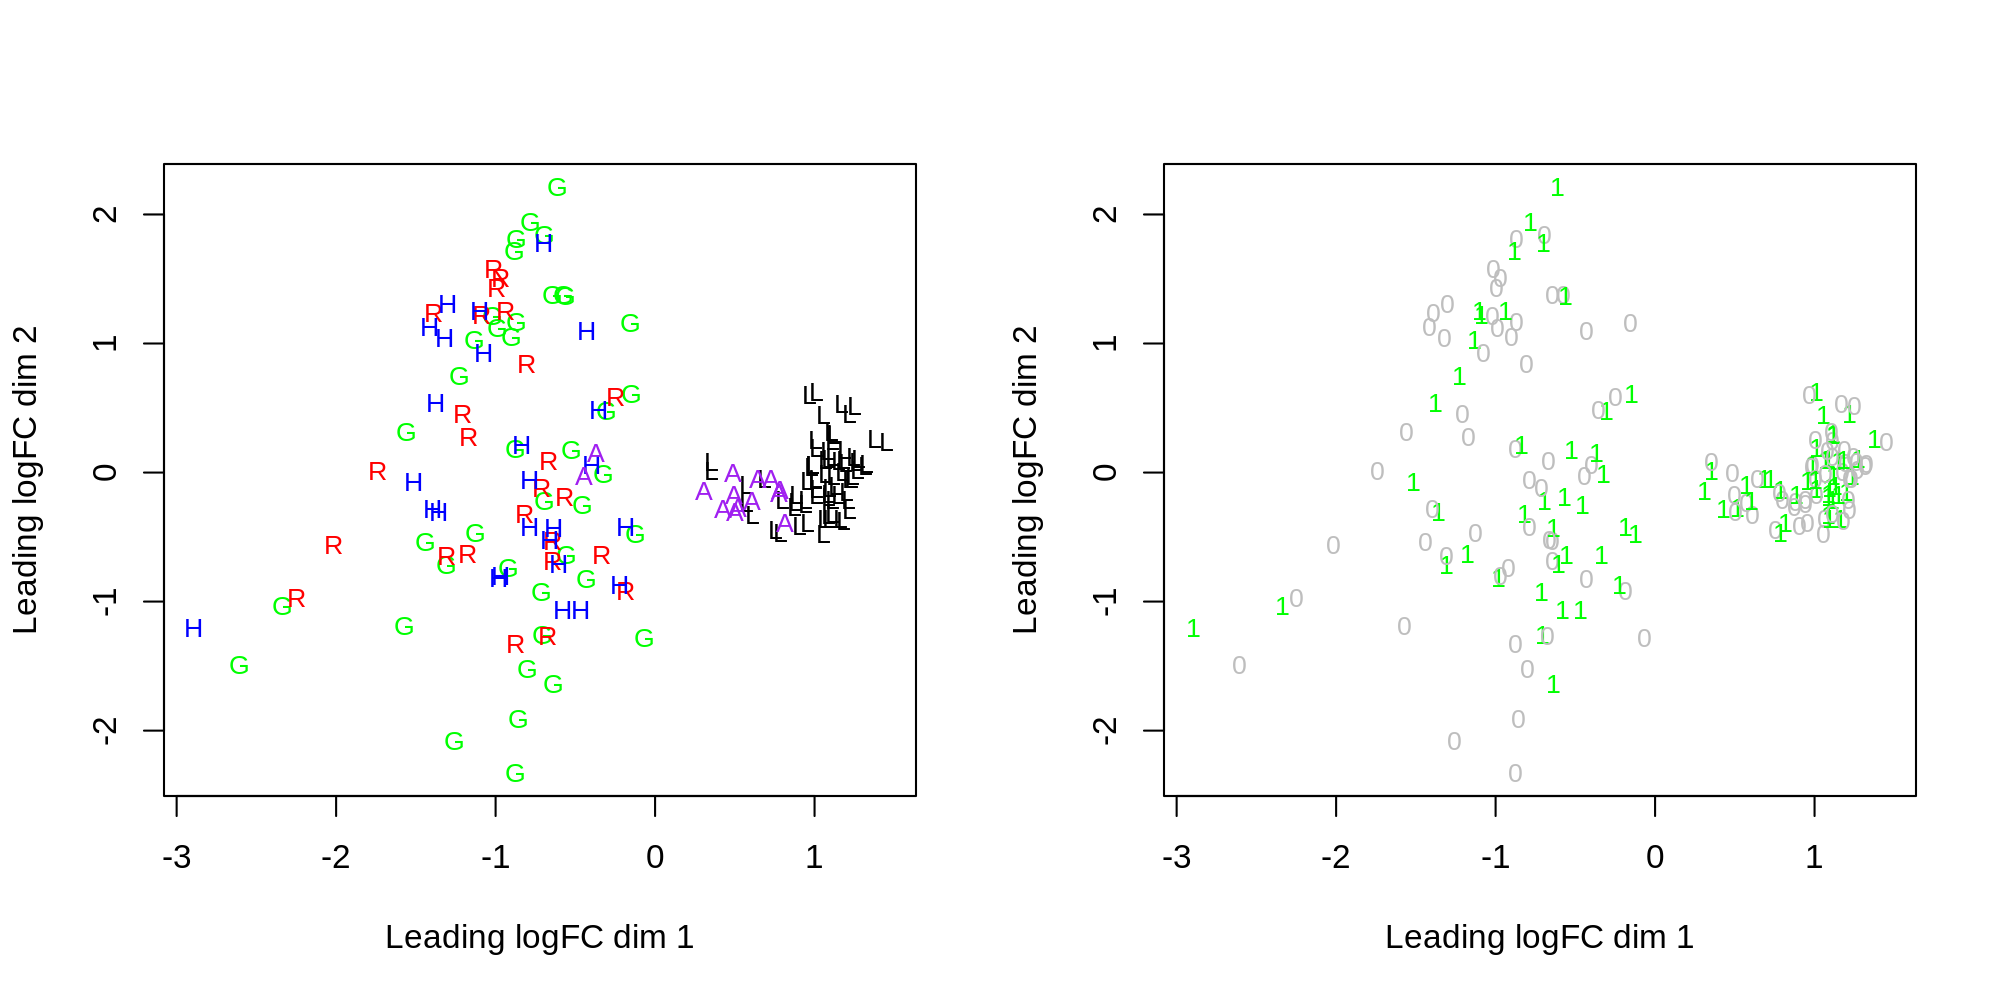

In [11]:
# dge_list <- DGEList(counts=exp, group=as.factor(ph$Source))
options(repr.plot.height=5, repr.plot.width=10, repr.plot.res=200)
par(mfrow=c(1,2))
plotMDS(trainTransformed, labels=ph$src, pch=19, col=ph$clr, cex=0.8)
plotMDS(trainTransformed, labels=as.character(ph$Response), pch=19, col=ph$clr_res, cex=0.8)

In [19]:
ph$batch <- "TIDE"
ph[ph$src == "L" | ph$src == "A",]$batch <- "LiuAmato"

# Differential Expression

`TODO:`
STICK TO EBAYES<br>
Use treat/eBayes(0 Response Source as factors)?<br>
Best way to implement design matrix<br>
Rank on P values<br>
Take top 150/500<br>

In [30]:
# design <- model.matrix(~0+ as.factor(ph$response) + as.factor(ph$batch))
design <- model.matrix(~0+as.factor(ph$Response) + as.factor(ph$batch))


In [35]:
#eBayes/ treat
# bayes <- eBayes(lin_mod)
# output <- topTable(lin_mod, number=Inf)
design <- model.matrix(~0+as.factor(ph$Response) + as.factor(ph$src))
lin_mod <- lmFit(trainTransformed,design)
lin_mod <- eBayes(lin_mod)
output <- topTable(lin_mod, number=Inf, coef = 1)
ordered_output <- output[order(output$P.Value),]
# ordered_output
nrow(ordered_output[ordered_output$P.Value < 0.05, ])
# ordered_output[ordered_output$P.Value < 0.05, ]

[1] 8639

In [ ]:
model.matrix(~0+as.factor(ph$Response) + as.factor(ph$src))

In [34]:
quantile(ordered_output$P.Value)

0%          25%          50%          75%         100% 
1.955468e-48 4.201982e-05 2.067991e-02 2.892016e-01 9.999073e-01

In [ ]:
ph$Source

In [ ]:
a <- exp["5588", ]
b <- ph$clr_res
c <- data.frame(expr=a, clr=b, stringsAsFactors=FALSE)
c <- c[order(c$clr),]
boxplot(c[c$clr=="gray",]$expr, c[c$clr=="green",]$expr)

# Overlap ML vs DiffEx

In [ ]:
n.rnd <- 100
n.itr <- 100
ord.gl <- rownames(ordered_output)
# ml.gl <- ord.gl[1:1000][sample(1000, 100)]  # change this
ml.gl <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/ml.list.rds")
rnd.list <- list()
for(i in 1:n.itr){
    rnd.pos <- sample(nrow(output), n.rnd)  # index 
    rnd.gl <- rownames(output)[rnd.pos]
    perc.rnd.gl <- c(length(which(rnd.gl %in% ord.gl[1:100])),
                     length(which(rnd.gl %in% ord.gl[1:200])),
                     length(which(rnd.gl %in% ord.gl[1:300])),
                     length(which(rnd.gl %in% ord.gl[1:400])),
                     length(which(rnd.gl %in% ord.gl[1:500])),
                     length(which(rnd.gl %in% ord.gl[1:600])),
                     length(which(rnd.gl %in% ord.gl[1:700])),
                     length(which(rnd.gl %in% ord.gl[1:800])),
                     length(which(rnd.gl %in% ord.gl[1:900])),
                     length(which(rnd.gl %in% ord.gl[1:1000]))
                     )*100/length(rnd.gl)
    rnd.list[[i]] <- perc.rnd.gl
}
rnd.mat <- do.call(rbind, rnd.list)

#
perc.ml.gl <- c(length(which(ml.gl %in% ord.gl[1:100])),
                 length(which(ml.gl %in% ord.gl[1:200])),
                 length(which(ml.gl %in% ord.gl[1:300])),
                 length(which(ml.gl %in% ord.gl[1:400])),
                 length(which(ml.gl %in% ord.gl[1:500])),
                 length(which(ml.gl %in% ord.gl[1:600])),
                 length(which(ml.gl %in% ord.gl[1:700])),
                 length(which(ml.gl %in% ord.gl[1:800])),
                 length(which(ml.gl %in% ord.gl[1:900])),
                 length(which(ml.gl %in% ord.gl[1:1000]))
                 )*100/length(ml.gl)

In [ ]:
# par(mfrow=c(2, 1))
par(mgp=c(3, 0.7, 0), cex.lab=0.7)
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
boxplot(rnd.mat, outline=FALSE, names=c("Top100","Top200", "Top300", "Top400", "Top500","Top600",
                                       "Top700", "Top800", "Top900","Top1000"), 
        xlab= "Ranked DiffExp", 
        ylab = "% Overlap Gene List",
        ylim=c(0,100),
        las = 2,
        cex.axis=0.7)
points(perc.ml.gl, col="red")
grid(lty="dashed")
# axis(1, at=1:10, labels=c("Top100","Top200", "Top300", "Top400", "Top500","Top600",
#                            "Top700", "Top800", "Top900","Top1000"))
# axis(2, at=c(0, 20, 40, 60, 80, 100), labels=c("0", "20", "40", "60", "80", "100"))

what fration of 200 ML genes fall within ranked n number of DE genes -> red dot <br>
what fraction of 200 random genes fall within ranked n number of DE genes(100 iterations) -> boxplot

# Overlap FCBF vs DiffEx

In [ ]:
fbcf.gl <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/fcbf34.list.rds")

perc.fbcf.gl <- c(length(which(fbcf.gl %in% ord.gl[1:100])),
                 length(which(fbcf.gl %in% ord.gl[1:200])),
                 length(which(fbcf.gl %in% ord.gl[1:300])),
                 length(which(fbcf.gl %in% ord.gl[1:400])),
                 length(which(fbcf.gl %in% ord.gl[1:500])),
                 length(which(fbcf.gl %in% ord.gl[1:600])),
                 length(which(fbcf.gl %in% ord.gl[1:700])),
                 length(which(fbcf.gl %in% ord.gl[1:800])),
                 length(which(fbcf.gl %in% ord.gl[1:900])),
                 length(which(fbcf.gl %in% ord.gl[1:1000]))
                 )*100/length(fbcf.gl)

In [ ]:
boxplot(rnd.mat, outline=FALSE, names=c("Top100","Top200", "Top300", "Top400", "Top500","Top600",
                                       "Top700", "Top800", "Top900","Top1000"), 
        xlab= "Ranked DiffExp", 
        ylab = "% Overlap Gene List",
        ylim=c(0,100),
        las = 2,
        cex.axis=0.7)
points(perc.fbcf.gl, col="red")
grid(lty="dashed")
# axis(1, at=1:10, labels=c("Top100","Top200", "Top300", "Top400", "Top500","Top600",
#                            "Top700", "Top800", "Top900","Top1000"))
# axis(2, at=c(0, 20, 40, 60, 80, 100), labels=c("0", "20", "40", "60", "80", "100"))

# Overlap top 200 variance vs DiffEx

In [ ]:
top200var.gl <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/top200var.list.rds")

perc.top200var.gl <- c(length(which(top200var.gl %in% ord.gl[1:100])),
                 length(which(top200var.gl %in% ord.gl[1:200])),
                 length(which(top200var.gl %in% ord.gl[1:300])),
                 length(which(top200var.gl %in% ord.gl[1:400])),
                 length(which(top200var.gl %in% ord.gl[1:500])),
                 length(which(top200var.gl %in% ord.gl[1:600])),
                 length(which(top200var.gl %in% ord.gl[1:700])),
                 length(which(top200var.gl %in% ord.gl[1:800])),
                 length(which(top200var.gl %in% ord.gl[1:900])),
                 length(which(top200var.gl %in% ord.gl[1:1000]))
                 )*100/length(top200var.gl)

In [ ]:
boxplot(rnd.mat, outline=FALSE, names=c("Top100","Top200", "Top300", "Top400", "Top500","Top600",
                                       "Top700", "Top800", "Top900","Top1000"), 
        xlab= "Ranked DiffExp", 
        ylab = "% Overlap Gene List",
        ylim=c(0,100),
        las = 2,
        cex.axis=0.7)
points(perc.top200var.gl, col="red")
grid(lty="dashed")

# Overlap ranger vs DiffEx

In [ ]:
ranger200.gl <- readRDS("/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/ranger.imp200.rds")

perc.ranger200.gl <- c(length(which(ranger200.gl %in% ord.gl[1:100])),
                 length(which(ranger200.gl %in% ord.gl[1:200])),
                 length(which(ranger200.gl %in% ord.gl[1:300])),
                 length(which(ranger200.gl %in% ord.gl[1:400])),
                 length(which(ranger200.gl %in% ord.gl[1:500])),
                 length(which(ranger200.gl %in% ord.gl[1:600])),
                 length(which(ranger200.gl %in% ord.gl[1:700])),
                 length(which(ranger200.gl %in% ord.gl[1:800])),
                 length(which(ranger200.gl %in% ord.gl[1:900])),
                 length(which(ranger200.gl %in% ord.gl[1:1000]))
                 )*100/length(ranger200.gl)

In [ ]:
boxplot(rnd.mat, outline=FALSE, names=c("Top100","Top200", "Top300", "Top400", "Top500","Top600",
                                       "Top700", "Top800", "Top900","Top1000"), 
        xlab= "Ranked DiffExp", 
        ylab = "% Overlap Gene List",
        ylim=c(0,100),
        las = 2,
        cex.axis=0.7)
points(perc.ranger200.gl, col="red")
grid(lty="dashed")

# Output DiffEx Genes

In [ ]:
limma85 <- rownames(ordered_output[ordered_output$P.Value < 0.05, ])
saveRDS(limma85, 
        "/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/limma85.list.rds")

In [ ]:
length(limma85)

In [ ]:
ordered_output[ordered_output$P.Value < 0.05, ]

make r function to print plot:
remove random part
litsur, jmim, prat
4 rows * 4 columns -> options, par

In [ ]:
cmn_path <- "/home/jp/ICP_Responders/ML/GideHugoRiaz_AntiPD1/Pre-processingFeatureSelection/"

plot_list <- function(pathRDS = NULL, group = NULL){
                    fbcf.gl <- readRDS(pathRDS)


                    perc.fbcf.gl <- c(length(which(fbcf.gl %in% ord.gl[1:100])),
                                     length(which(fbcf.gl %in% ord.gl[1:200])),
                                     length(which(fbcf.gl %in% ord.gl[1:300])),
                                     length(which(fbcf.gl %in% ord.gl[1:400])),
                                     length(which(fbcf.gl %in% ord.gl[1:500])),
                                     length(which(fbcf.gl %in% ord.gl[1:600])),
                                     length(which(fbcf.gl %in% ord.gl[1:700])),
                                     length(which(fbcf.gl %in% ord.gl[1:800])),
                                     length(which(fbcf.gl %in% ord.gl[1:900])),
                                     length(which(fbcf.gl %in% ord.gl[1:10000]))
                                     )*100/length(fbcf.gl)


                    plot(perc.fbcf.gl, col="red", main=group,
                         axes = FALSE,
                         xlab= "Ranked DiffExp", 
                         ylab = "% Overlap Gene List",
                         ylim=c(0,100))
                    axis(1, at=1:10, labels=c("100","200", "300", "400", "500","600",
                                                           "700", "800", "900","1000"),
                        las=2) 
                    axis(2, at=c(0, 20, 40, 60, 80, 100), labels=c(0, 20, 40, 60, 80, 100))
                    grid(lty="dashed")
                    }

options(repr.plot.height=7, repr.plot.width=12, repr.plot.res=300)
par(mfrow=c(2, 4), mgp=c(3, 0.7, 0))
plot_list(paste0(cmn_path, "ml.list.rds"), "MergedRank")
plot_list(paste0(cmn_path, "fcbf34.list.rds"), "FCBF")
plot_list(paste0(cmn_path, "top200var.list.rds"), "Variance Rank")
plot_list(paste0(cmn_path, "limma85.list.rds"), "Limma")
plot_list(paste0(cmn_path, "ranger.imp200.rds"), "Random Forest Permutation")
plot_list(paste0(cmn_path, "jmim.list.rds"), "Mutual Information")
plot_list(paste0(cmn_path, "litsur.list.rds"), "Literature Survey")
plot_list(paste0(cmn_path, "prat.list.rds"), "Prat et al.")

In [ ]:
length(which(fbcf.gl %in% ord.gl[1:100]))
length(fbcf.gl)
length(ord.gl)